In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from random import randint, seed, uniform
import numpy as np
import swarms

from constants import PC, MSUN, LSUN, JY, MMOON, MJUP, RJUP, AU, MEARTH, YEAR, MICRON

try:
    plt.style.use('paper')
except:
    pass

In [3]:
GPI = pd.read_csv("../csvs/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0
GPI.tail()
# for i in range(len(GPI['S_Type'])):
#     print(GPI['S_Type'][i][0])

,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mbol,Lum,Teff,Mass,Age
594,B9V,48.5835,NaN,4.622,10860,B,9,0.570,46.558609,10850.0,2.455,0
595,A7III/IV,67.1100,NaN,5.879,7834,A,7,2.445,8.279422,8000.0,1.595,0
596,F6V,35.3895,6.370,5.787,6255,F,6,3.860,2.249055,6400.0,1.160,0
597,K2V,21.9270,7.194,6.007,0,K,2,5.620,0.444631,4930.0,0.738,0
598,A1V,47.0754,NaN,4.949,9057,A,1,1.440,20.892961,9370.0,2.005,0


In [4]:
def Imag(row):
    star = swarms.Star(L=row['Lum']*LSUN, M=row['Mass']*MSUN, T=row['Teff'], d=row['Distance_distance']*PC)
    return star.Imag

In [5]:
GPI['Imag'] = GPI.apply(Imag, axis=1)
GPI.tail()

,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mbol,Lum,Teff,Mass,Age,Imag
594,B9V,48.5835,NaN,4.622,10860,B,9,0.570,46.558609,10850.0,2.455,0,4.344432
595,A7III/IV,67.1100,NaN,5.879,7834,A,7,2.445,8.279422,8000.0,1.595,0,6.353499
596,F6V,35.3895,6.370,5.787,6255,F,6,3.860,2.249055,6400.0,1.160,0,6.080366
597,K2V,21.9270,7.194,6.007,0,K,2,5.620,0.444631,4930.0,0.738,0,6.626458
598,A1V,47.0754,NaN,4.949,9057,A,1,1.440,20.892961,9370.0,2.005,0,4.853445


In [6]:
seed(0)

def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def draw_star(GPI):
    if isinstance(GPI, pd.Series):
        star = GPI
    else:
        idx = randint(0, GPI.shape[0]-1)
        star = GPI.loc[idx]
    return star['Mass']*MSUN, star['Lum']*LSUN, star['Fe_H_Teff'], star['Distance_distance']*PC, star['Imag'], star['Age']*YEAR, star['S_Type'][0]

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 20 # Mearth (Nep)
    Mmax = 5*318 # Mearth (Jup)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = star.d/PC*IWA# AU
        amax = star.d/PC*OWA # AU
        a = loguniform(amin, amax)
        return swarms.Planet(star, M=ms[idx]*MEARTH , R=None, a=a*AU, Q=Q, Z='002', age=age)

def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (np.pi*a_pl**2)

In [7]:
def sample(GPI):
    Mstar, Lstar, Tstar, d_pl, Imag, age, star_type = draw_star(GPI)
    
    if age == 0:
        age = loguniform(1e7, 1e8) * YEAR
    star = swarms.Star(Lstar, Mstar, Tstar, d=d_pl)
    if 10780000 >= age/YEAR:
        return None, None, None, None, None, None, None
    planet = draw_planet(star, age, IWA=0.2, OWA=1.2)
   # print(planet.a)
    if planet.a == None:
        return None, None, None, None, None, None, None
    
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = uniform(0.2, 0.4) # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = 0.32 
    Dt = loguniform(10, 1000) # m
    lamb = 1.65 * MICRON
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, M0=M0, Dmax=Dmax, Dt=Dt, eta=eta, Q=Q, g=g, rho=rho, 
                             fQ=fQ, Nstr=Nstr, Dmin_min=lamb, age=age)
    
    CRscatSwarm = swarm.computeCRscat()
    return CRscatSwarm, planet.a/AU, d_pl/PC, Imag, planet.M, star_type, star

In [8]:
%%time
seed(0)
M0 = 1*MEARTH
Nsamples = 600
star_type = []
stars = []
CR, a, d, Imag, Mplt = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CR[i], a[i], d[i], Imag[i], Mplt[i], stype, s = sample(GPI)
    star_type.append(stype)
    stars.append(s)

CPU times: user 13.3 s, sys: 961 ms, total: 14.2 s
Wall time: 14.3 s


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


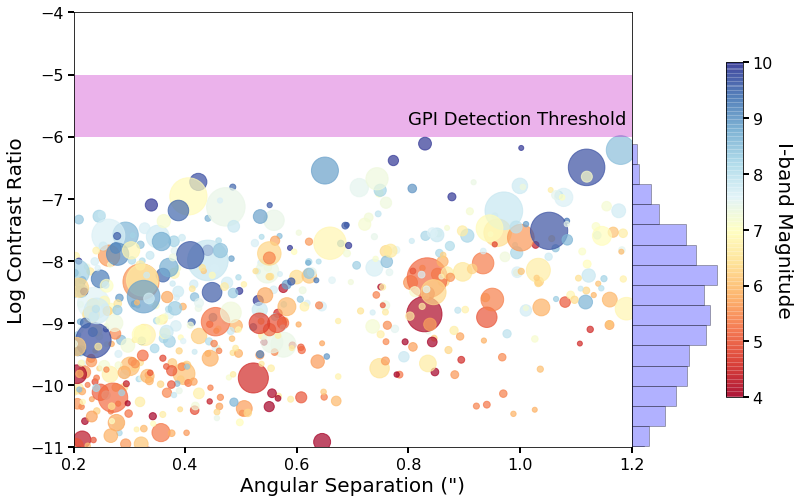

In [9]:
mask = (~np.isnan(CR)) & (a/d > 0.2) & (a/d < 10)
cm = plt.cm.get_cmap('RdYlBu')

sep = a[mask]/d[mask]
logCR = np.log10(CR[mask])
Imag2 = Imag[mask]
Mpltcut = Mplt[mask]
color_flags = [False, False, False, False, False, False]
fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)
sc = axarr[0].scatter(sep, logCR, c=Imag2, s=400*Mpltcut/MEARTH/318, cmap=cm, vmin=4, vmax=10, alpha=0.7)
        
axarr[0].fill_between(np.linspace(0.2, 10, 10), -6, -5, facecolor='m', alpha=0.3)
    
axarr[0].set_xlim([0.2, 1.2])
axarr[0].set_ylim([-11, -4])
axarr[0].set_xlabel('Angular Separation (")')
axarr[0].set_ylabel('Log Contrast Ratio')

plt.subplots_adjust(wspace=0)
axarr[0].text(0.8, -5.8, "GPI Detection Threshold", color='k', fontsize=18)

cbar = plt.colorbar(sc)
cbar.set_label('I-band Magnitude', labelpad=20, rotation=270)

axarr[1].set_axis_off()
vals, bins, patches = axarr[1].hist(np.log10(CR[mask]), orientation='horizontal', bins=20, facecolor='b', ec='k', alpha=0.3)
fig.savefig('fig5.pdf', bbox_inches='tight')